## Tutorial 2: Variational Trajectory Planning - Build a motion planner and upload benchmark solutions

https://commonroad.in.tum.de/tutorials/optimization-solution

## Exercise 0: Read the created CommonRoad scenario

The CommonRoadFileReader reads the Scenario and the PlanningProblemSet from a CommonRoad XML-file. Please read the scenario from the CommonRoad file.

In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
from commonroad.common.file_reader import CommonRoadFileReader
from commonroad.visualization.mp_renderer import MPRenderer

/Users/jihoonkim/opt/anaconda3/envs/commonroad-py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


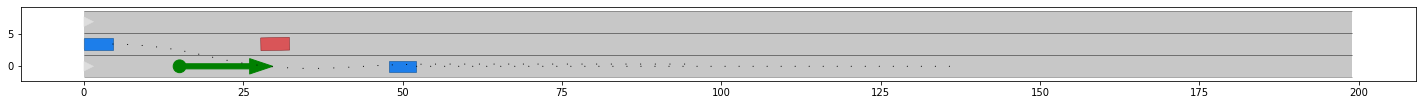

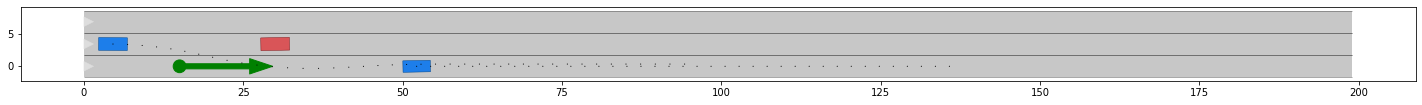

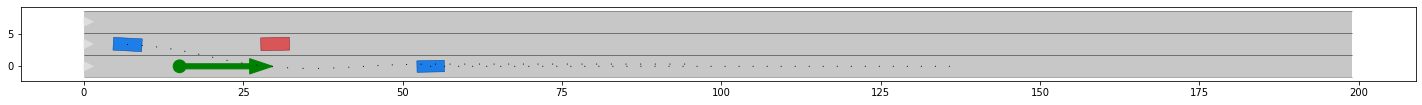

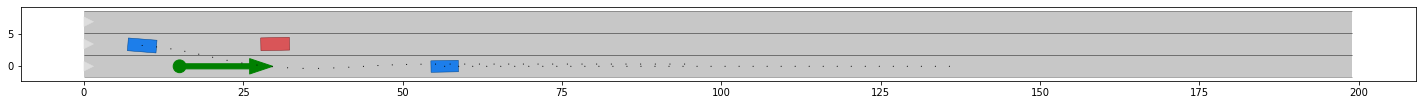

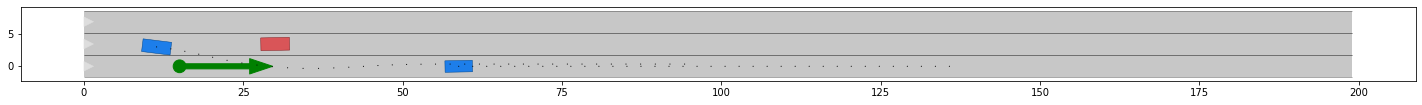

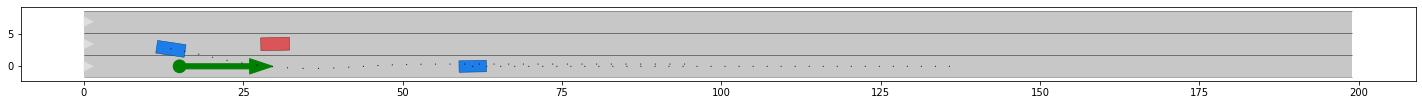

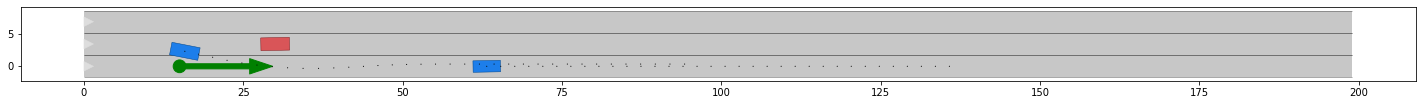

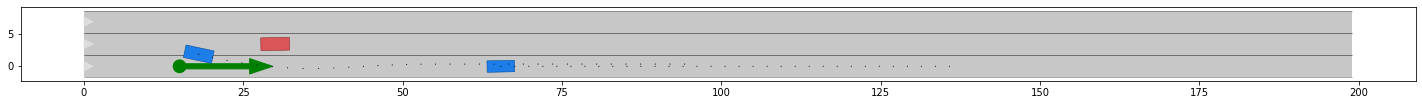

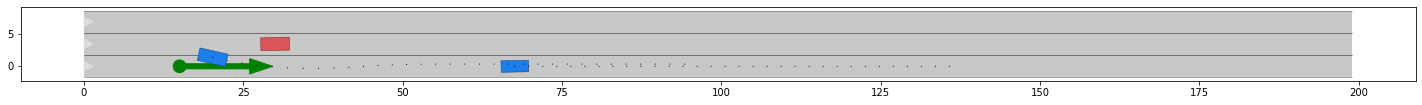

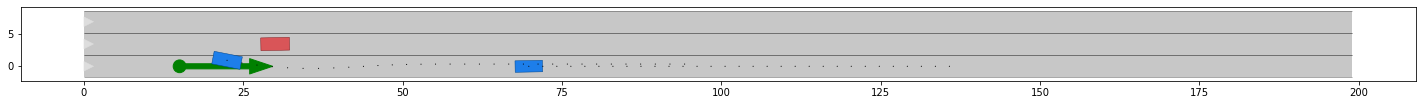

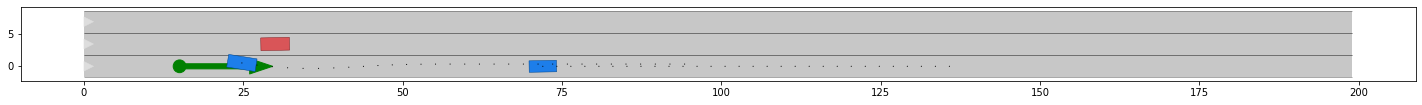

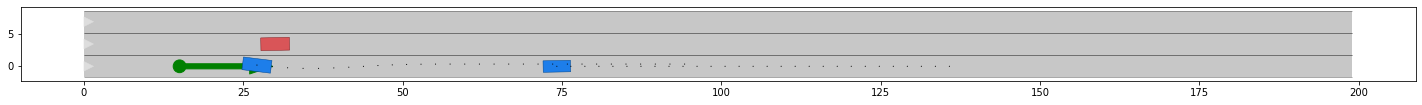

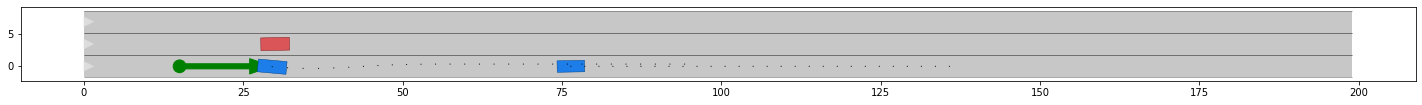

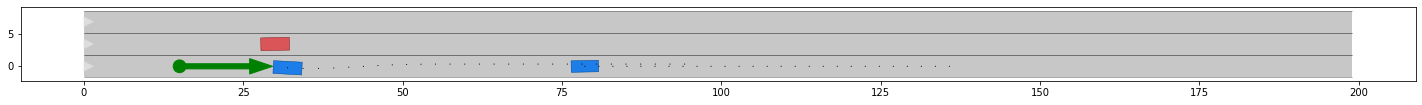

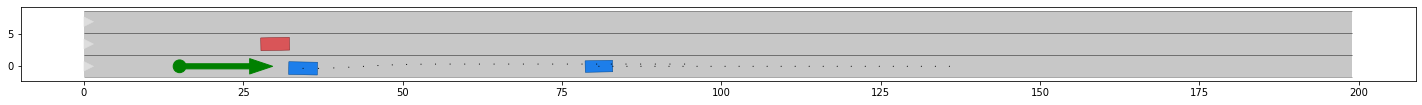

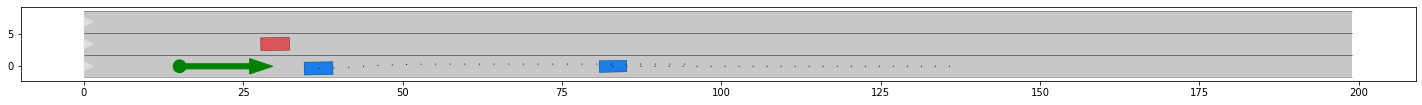

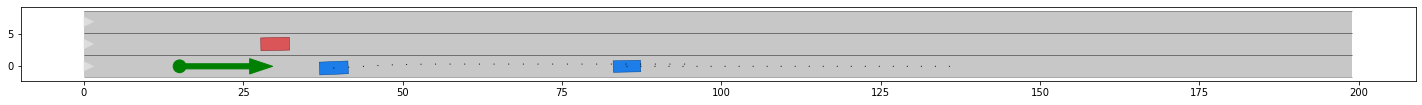

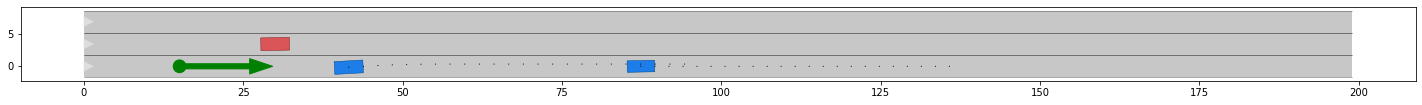

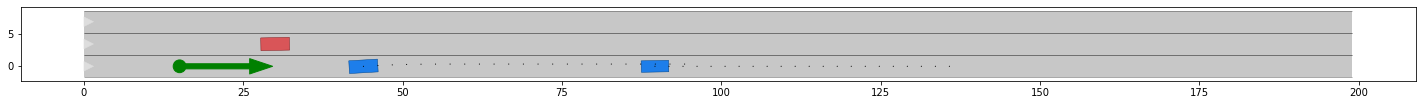

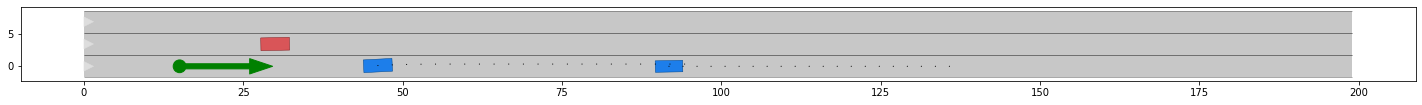

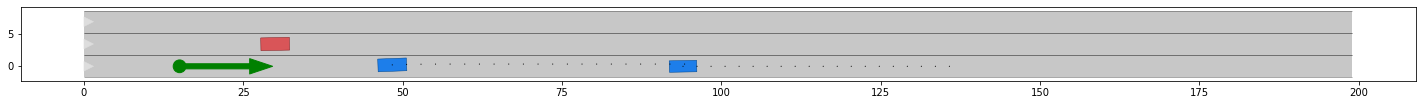

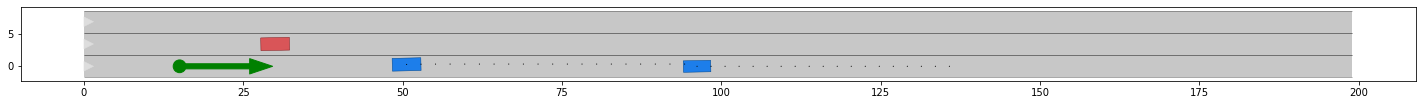

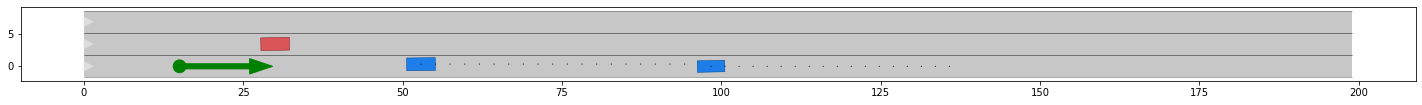

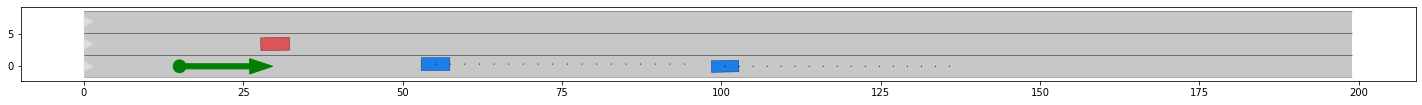

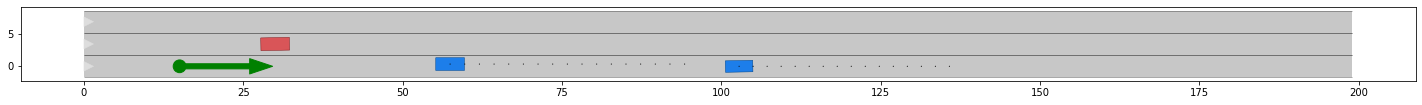

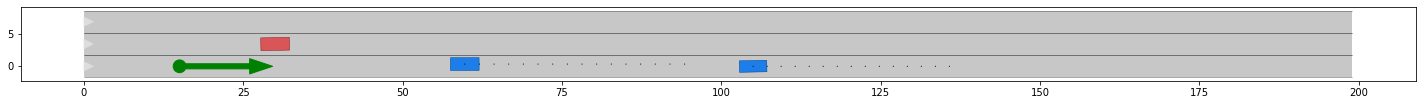

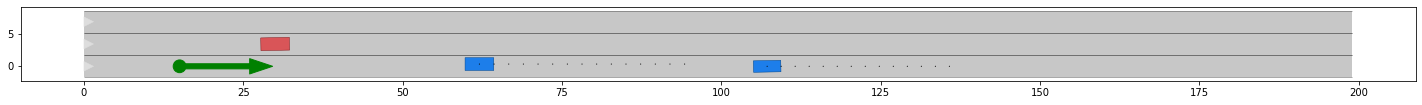

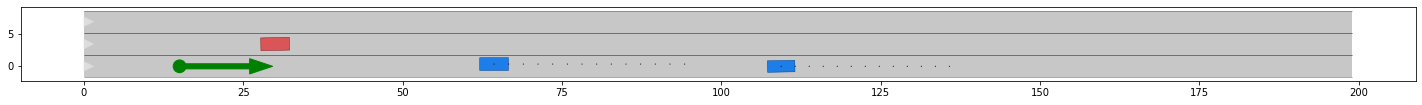

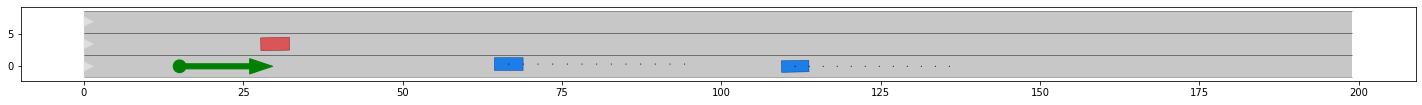

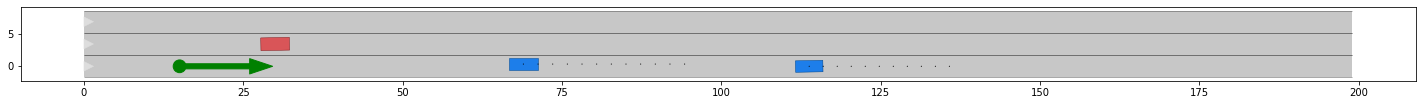

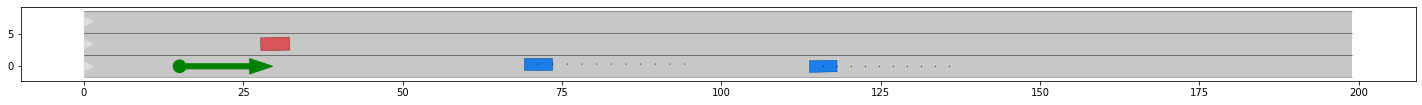

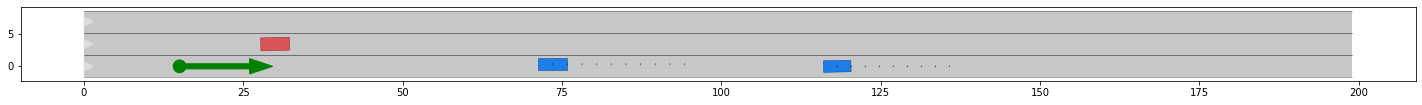

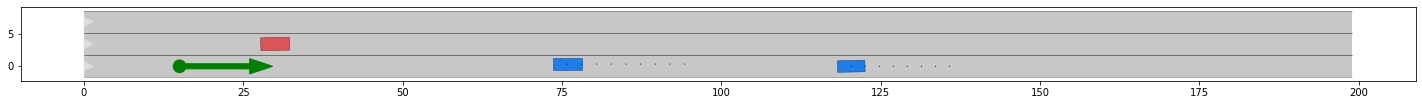

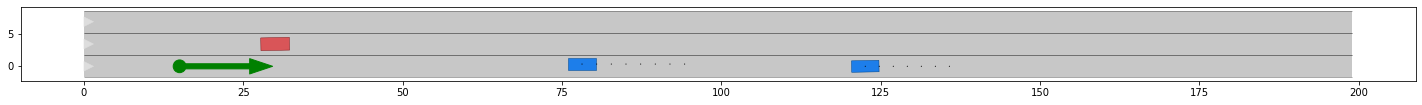

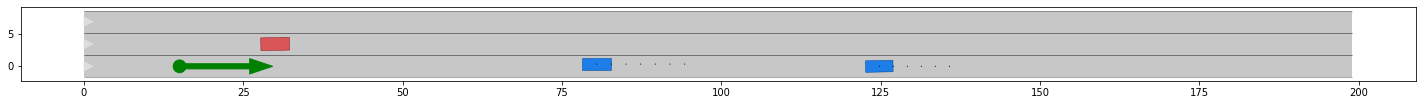

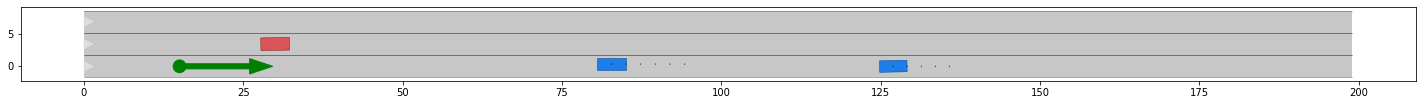

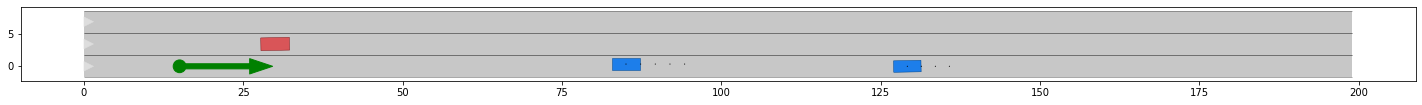

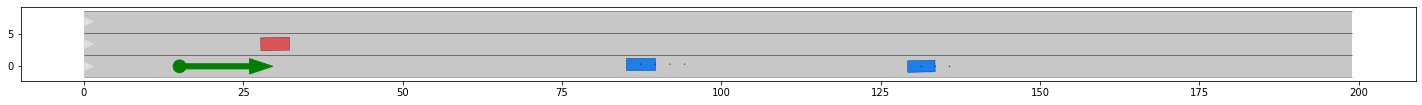

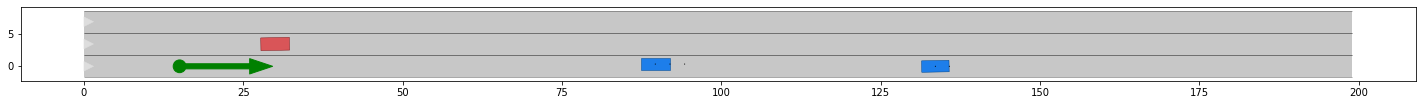

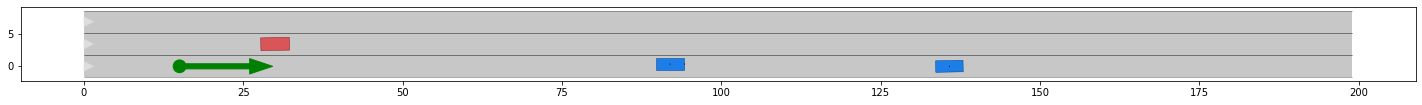

In [5]:
# load the CommonRoad scenario that has been created in the CommonRoad tutorial
# file_path = os.path.join(os.getcwd(), 'ZAM_Tutorial-1_2_T-1.xml')
file_path = os.path.join(os.getcwd(), 'scenarios/tutorial/ZAM_Tutorial-1_2_T-2.xml')

scenario, planning_problem_set = CommonRoadFileReader(file_path).open()

# plot the scenario for each time step
for i in range(0, 40):
    plt.figure(figsize=(25, 10))
    rnd = MPRenderer()
    scenario.draw(rnd, draw_params={'time_begin': i})
    planning_problem_set.draw(rnd)
    rnd.render()

## Helper Functions for visualization

In [7]:
try:
    import matplotlib.pyplot as plt
except ImportError:
    print('Matplotlib not installed. Please use pip(3) to install required package!')

try:
    import numpy as npy
except ImportError:
    print('Numpy not installed. Please use pip(3) to install required package!')

try:
    import vehiclemodels
except ImportError:
    print('commonroad-vehicle-models not installed. Please use pip install to install required package!')

try:
    import pkg_resources
    pkg_resources.require("scipy>=1.1.0")
    pkg_resources.require("cvxpy>=1.0.0")
    from cvxpy import *
except ImportError:
    print('CVXPy not installed or wrong version. Please use pip(3) to install required package!')

class TIConstraints:
    a_min = -8
    a_max = 15
    s_min = 0
    s_max = 150
    v_min = 0
    v_max = 35
    j_min = -30
    j_max = 30


def plot_state_vector(x : Variable, c : TIConstraints, s_obj = None):
    plt.figure(figsize=(10,10))
    N = x.shape[1]-1
    s_max = npy.maximum(150,100+0*npy.ceil(npy.amax((x.value)[0,:].flatten())*1.1/10)*10)

    # Plot (x_t)_1.
    plt.subplot(4,1,1)
    x1 = (x.value)[0,:].flatten()
    plt.plot(npy.array(range(N+1)),x1,'g')
    if s_obj is not None:
        plt.plot(npy.array(range(1,N+1)),s_obj[0],'b')
        plt.plot(npy.array(range(1,N+1)),s_obj[1],'r')
    plt.ylabel(r"$s$", fontsize=16)
    plt.yticks(npy.linspace(c.s_min, s_max, 3))
    plt.ylim([c.s_min, s_max])
    plt.xticks([])

    # Plot (x_t)_2.
    plt.subplot(4,1,2)
    x2 = (x.value)[1,:].flatten()
    plt.plot(npy.array(range(N+1)),x2,'g')
    plt.yticks(npy.linspace(c.v_min,c.v_max,3))
    plt.ylim([c.v_min, c.v_max+2])
    plt.ylabel(r"$v$", fontsize=16)
    plt.xticks([])

    # Plot (x_t)_3.
    plt.subplot(4,1,3)
    x2 = (x.value)[2,:].flatten()
    plt.plot(npy.array(range(N+1)),x2,'g')
    plt.yticks(npy.linspace(c.a_min,c.a_max,3))
    plt.ylim([c.a_min, c.a_max+2])
    plt.ylabel(r"$a$", fontsize=16)
    plt.xticks([])

    # Plot (x_t)_4.
    plt.subplot(4,1,4)
    x2 = (x.value)[3,:].flatten()
    plt.plot(npy.array(range(N+1)), x2,'g')
    plt.yticks(npy.linspace(c.j_min,c.j_max,3))
    plt.ylim([c.j_min-1, c.j_max+1])
    plt.ylabel(r"$j$", fontsize=16)
    plt.xticks(npy.arange(0,N+1,5))
    plt.xlabel(r"$k$", fontsize=16)
    plt.tight_layout()
    plt.show()

## Variables of the Optimization Problem

In [8]:
# problem data
N  = 40  # number of time steps
n  = 4   # length of state vector 
m  = 1   # length of input vector
dT = scenario.dt # time step


# set up variables
x = Variable(shape=(n,N+1)) # optimization vector x contains n states per time step 
u = Variable(shape=(N)) # optimization vector u contains 1 state

# set up constraints
c = TIConstraints()
c.a_min = -6 # Minimum feasible acceleration of vehicle
c.a_max = 6 # Maximum feasible acceleration of vehicle
c.s_min = 0 # Minimum allowed position
c.s_max = 100 # Maximum allowed position
c.v_min = 0 # Minimum allowed velocity (no driving backwards!)
c.v_max = 35 # Maximum allowed velocity (speed limit)
c.j_min = -15 # Minimum allowed jerk 
c.j_max = 15 # Maximum allowed jerk

# weights for cost function
w_s = 0
w_v = 8
w_a = 2
w_j = 2
Q = npy.eye(n)*npy.transpose(npy.array([w_s,w_v,w_a,w_j]))
w_u = 1
R = w_u

In [9]:
## Exercise 1: Consider the vehicle model

In order to obtain kinematically feasible motion plans, the optimization problem needs to respect the constraints of the vehicle model. We use a linear vehicle model, which can be written in the following state-space form:

Please fill the matrices A and B according to the fourth-order point-mass model, discretized using the time step dT.

In [10]:
A = npy.array([[1,dT,(dT**2)/2,(dT**3)/6],
               [0,1,dT,(dT**2)/2],
               [0,0,1,dT],
               [0,0,0,1]])
B = npy.array([(dT**4)/24,
               (dT**3)/6,
               (dT**2)/2,
               dT]).reshape([n,])

## Formulation of the Optimization Problem

We are now able to formulate the optimization problem. Please set the initial state of the ego vehicle with a velocity of 0 m/s and its reference velocity. Subsequently, we create the cost terms and constraints of the optimization problem

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Mar 11 04:27:22 PM: Your problem has 204 variables, 41 constraints, and 0 parameters.
(CVXPY) Mar 11 04:27:23 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 11 04:27:23 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 11 04:27:23 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 11 04:27:23 PM: Compiling problem (target solver=OSQP).
(CVXPY) Mar 11 04:27:23 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffi

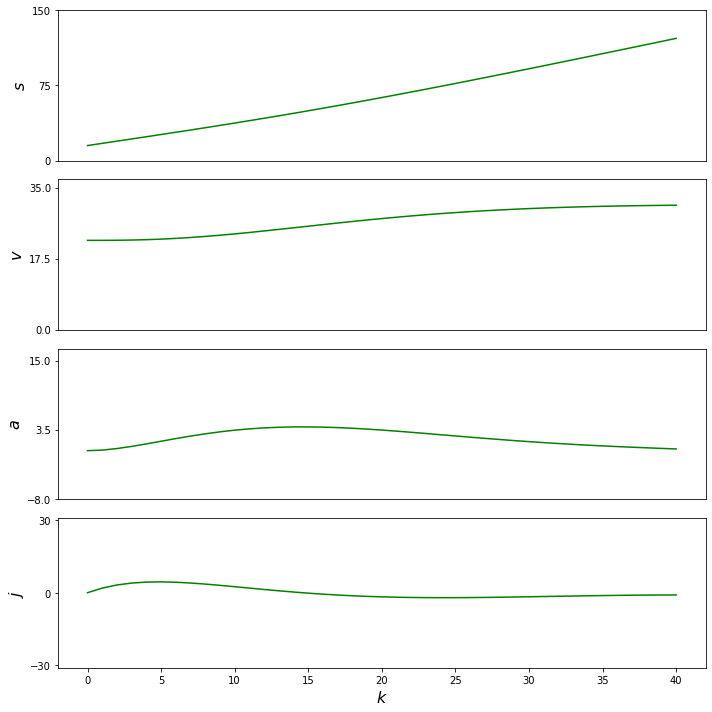

In [11]:
# get the initial state of the ego vehicle from the planning problem set
planning_problem = planning_problem_set.find_planning_problem_by_id(100)
initial_state = planning_problem.initial_state

# initial state of vehicle for the optimization problem (longitudinal position, velocity, acceleration, jerk)
x_0 = npy.array([initial_state.position[0],
                 initial_state.velocity,
                 0.0,
                 0.0]).reshape([n,]) # initial state

# reference velocity
v_ref = 30.0
# Set up optimization problem
states = []
cost = 0
# initial state constraint
constr = [x[:,0] == x_0]

for k in range(N):
    # cost function
    cost += quad_form(x[:,k+1] - npy.array([0,v_ref,0,0],), Q)\
           + R * u[k] ** 2
    # time variant state and input constraints
    constr.append(x[:,k+1] == A @ x[:,k] + B * u[k])

# sums problem objectives and concatenates constraints.
# create optimization problem
prob = Problem(Minimize(cost), constr)

# Solve optimization problem
prob.solve(verbose=True)
print("Problem is convex: ",prob.is_dcp())
print("Problem solution is "+prob.status)

# plot results
plot_state_vector(x, TIConstraints())

# Exercise 2: Consider additional constraints
    

The obtained trajectory reaches the desired reference velocity of the ego vehicle. However, the physical constraints are not fulfilled. Please add the physical constraints to the optimization problem in order to obtain kinematically feasible trajectories.

Problem is convex:  True
Problem solution is optimal


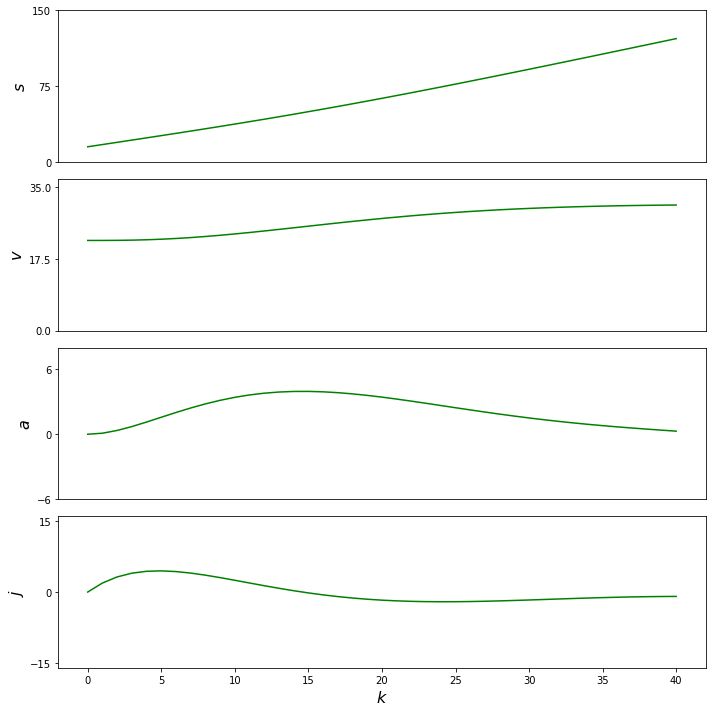

In [12]:
tiConstraints = [x[1,:] <= c.v_max, x[1,:] >= c.v_min] # velocity
tiConstraints += [x[2,:] <= c.a_max, x[2,:] >= c.a_min] # acceleration
tiConstraints += [x[3,:] <= c.j_max, x[3,:] >= c.j_min] # jerk

# Adjust problem
prob = Problem(Minimize(cost), constr + tiConstraints)

# Solve optimization problem
prob.solve()
print("Problem is convex: ",prob.is_dcp())
print("Problem solution is "+prob.status)

# plot results
plot_state_vector(x, c)

# Exercise 3: Extract the prediction of obstacles

In our scenario, the ego vehicle is surrounded by two other traffic participants -- one following and one leading vehicle. In order to not cause a collision with these two vehicles, we need to consider the positions of the two vehicles in our optimization problem. Please obtain the minimum and maximum feasible position of the ego vehicle for each point in time. Please note that each obstacle has a certain shape.

Following vehicle id=42
Leading vehicle id=45


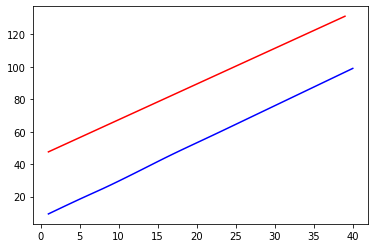

In [13]:
# extract obstacle from scenario
dyn_obstacles = scenario.dynamic_obstacles

# create constraints for minimum and maximum position
s_min = [] # minimum position constraint
s_max = [] # maximum position constraint

# go through obstacle list and distinguish between following and leading vehicle
for o in dyn_obstacles:
    if o.initial_state.position[0] < x_0[0]:
        print('Following vehicle id={}'.format(o.obstacle_id))
        prediction = o.prediction.trajectory.state_list
        for p in prediction:
            s_min.append(p.position[0]+o.obstacle_shape.length/2.+2.5)
    else:
        print('Leading vehicle id={}'.format(o.obstacle_id))
        prediction = o.prediction.trajectory.state_list
        for p in prediction:
            s_max.append(p.position[0]-o.obstacle_shape.length/2.-2.5)

# plot vehicle motions
plt.plot(range(1,len(s_min)+1),s_min,'b')
plt.plot(range(1,len(s_max)+1),s_max,'r')

## Exercise 4: Plan the motion of the ego vehicle

The obtained collision constraint allow us to avoid collisions with the following and leading vehicle. Please add the constraints to our optimization problem and obtain a trajectory.

In [14]:
N, len(s_max)

(40, 39)

In [15]:
# initial state of ego vehicle
x_0 = npy.array([initial_state.position[0],
                 initial_state.velocity,
                 0,
                 0]).reshape([n,]) # initial state

# reference velocity
v_ref = 30.0

# Set up optimization problem
cost = 0
constr = [x[:,0] == x_0]
for k in range(N):
    # cost function
    cost += quad_form(x[:,k+1] - npy.array([0,v_ref,0,0],), Q)\
           + R * u[k] ** 2
    # single state and input constraints
    constr.append(x[:,k+1] == A @ x[:,k] + B * u[k])
    # add obstacle constraint
    constr.append(x[0,k+1] <= s_max[k])
    constr.append(x[0,k+1] >= s_min[k])

# sums problem objectives and concatenates constraints.
prob = sum(states)
# add constraints for all states & inputs
prob = Problem(Minimize(cost), constr + tiConstraints)


# Solve optimization problem
prob.solve(verbose=True)

print("Problem is convex:",prob.is_dcp())
print("Problem solution is "+prob.status)

# plot results
plot_state_vector(x, c, [s_min,s_max])

x_result = x.value
s_ego = x_result[0,:].flatten()
v_ego = x_result[1,:].flatten()

IndexError: list index out of range